## Method:

For Encoder: given input thorugh hidden 3 layers, get mean, log_sigma enocde. And use a way to add mean and log_sigma as an input of Decoder.

For Decoder: Given input, and through 3 hidden 3 layers to get the output. Encoder and Decoder Activations are ReLU.

For Reconstruction of Encoder and Decoder loss: Use Mean Square Error. And backprop with encoder and decoder.

For Discriminator: Given input from enocder as negative samples q(z) and concate y data(dim: y+1, might tell from unknown) hoping to let discrimiator get more information from y. Distributionz as positive samples p(z). Activations are ReLU, but final activation is sigmoid to tell true or fake samples. Then calculate cost functions. Backpropgation  updates discriminator weights.

For Generator: Given input from enocder as negative samples q(z) and concate y data. Calculate loss and update enocder weights.

Optimizer is Adam

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt
import numpy as np
from sklearn.manifold import TSNE
import matplotlib as ml
import pylab as pl
%matplotlib inline

In [2]:
data = np.load('data.npy')
label = np.load('label.npy')

In [3]:
batch_size = 1
bacth_times = len(data) // batch_size
z_dim = 100
z_var = 100
class_mounts = 10

gen_lr, reg_lr = 0.0001, 0.00008 

In [4]:
def convert_y(data, classify):
    data_array = np.zeros((len(data), classify+1))
    for indx in range(len(data)):
        data_array[indx][data[indx]] = float(1.0)
    return data_array

In [5]:
def sample_Z(m, n):
    return np.random.normal(-1., 1., size=[m, n])

In [6]:
data_y = convert_y(label , class_mounts)

In [7]:
data_y = np.float32(data_y)

In [8]:
def random_bat(data_x, data_y):
    num_images = len(data_x)
    idx = np.random.choice(num_images, size= batch_size, replace=False)
    x_batch = data_x[idx, :]
    y_batch = data_y[idx, :]
    return x_batch, y_batch

# Weight

In [9]:
EncodeWeight_Var = {"w1" : tf.Variable(tf.truncated_normal([784, 500] ,stddev = 0.1)),\
              "w2": tf.Variable(tf.truncated_normal([500, 300] ,stddev = 0.1)),\
              "log":  tf.Variable(tf.truncated_normal([300, z_var] ,stddev = 0.1)),\
              "mean":  tf.Variable(tf.truncated_normal([300, z_var] ,stddev = 0.1))}

EncodeBias_Var = {"b1": tf.Variable( tf.constant(0.1, shape= [500])),\
            "b2": tf.Variable( tf.constant(0.1, shape= [300])),\
            "log": tf.Variable(tf.constant(0.1, shape= [z_var])),\
            "mean": tf.Variable(tf.constant(0.1, shape= [z_var]))}

In [10]:
DecodeWeight_Var = { "w1" : tf.Variable(tf.truncated_normal([z_var, 300] ,stddev = 0.1)),\
              "w2" : tf.Variable(tf.truncated_normal([300, 500] ,stddev = 0.1)),\
              "w3": tf.Variable(tf.truncated_normal([500, 784] ,stddev = 0.1))}

DecodeBias_Var = { "b1": tf.Variable( tf.constant(0.1, shape= [300])),\
            "b2": tf.Variable( tf.constant(0.1, shape= [500])),\
            "b3": tf.Variable( tf.constant(0.1, shape= [784]))}

In [11]:
DiscriminatorWeight_Var = { "w1" : tf.Variable(tf.truncated_normal([z_dim + class_mounts+1, 80] ,stddev = 0.1)),\
              "w2" : tf.Variable(tf.truncated_normal([80, 50] ,stddev = 0.1)),\
              "w3": tf.Variable(tf.truncated_normal([50, 1] ,stddev = 0.1))}

DiscriminatorBias_Var = { "b1": tf.Variable( tf.constant(0.1, shape= [80])),\
            "b2": tf.Variable( tf.constant(0.1, shape= [50])),\
            "b3": tf.Variable( tf.constant(0.1, shape= [1]))}

# List

In [12]:
var_encode = [EncodeWeight_Var["w1"], EncodeWeight_Var["w2"],EncodeWeight_Var["log"],EncodeWeight_Var["mean"]\
         , EncodeBias_Var["b1"], EncodeBias_Var["b2"],EncodeBias_Var["log"], EncodeBias_Var["mean"]]

In [13]:
var_d = [DiscriminatorWeight_Var["w1"], DiscriminatorWeight_Var["w2"], DiscriminatorWeight_Var["w3"]\
         , DiscriminatorBias_Var["b1"], DiscriminatorBias_Var["b2"], DiscriminatorBias_Var["b3"]]

In [14]:
var_endelist = [EncodeWeight_Var["w1"], EncodeWeight_Var["w2"], EncodeWeight_Var["log"],EncodeWeight_Var["mean"]\
         , EncodeBias_Var["b1"], EncodeBias_Var["b2"], EncodeBias_Var["log"], EncodeBias_Var["mean"], DecodeWeight_Var["w1"], DecodeWeight_Var["w2"],\
               DecodeWeight_Var["w3"], DecodeBias_Var["b1"], DecodeBias_Var["b2"], DecodeBias_Var["b3"]]

# Foward

In [15]:
def EnFoward(x):
    # encoder
    hidden_layer1 = tf.nn.relu( tf.matmul(x, EncodeWeight_Var["w1"]) + EncodeBias_Var["b1"])
    h_fc1_drop = tf.nn.dropout(hidden_layer1, keep_prob = 0.9)
    hidden_layer2 = tf.nn.relu( tf.matmul(h_fc1_drop, EncodeWeight_Var["w2"]) + EncodeBias_Var["b2"])
    hidden_drop2 = tf.nn.dropout(hidden_layer2, keep_prob = 0.9)
    
    z_mean = tf.matmul(hidden_drop2, EncodeWeight_Var['mean'])+ EncodeBias_Var['mean']
    z_log = tf.matmul(hidden_drop2, EncodeWeight_Var['log'])+ EncodeBias_Var['log']
    
    return z_mean, z_log

In [16]:
def DeFoward(x):
    #decoder
    hidden_z = tf.nn.relu( tf.matmul(x, DecodeWeight_Var["w1"]) + DecodeBias_Var["b1"])
    z_dropout = tf.nn.dropout(hidden_z, keep_prob = 0.9)
    hidden_layer1 = tf.nn.relu( tf.matmul(z_dropout, DecodeWeight_Var["w2"]) + DecodeBias_Var["b2"])
    hidden_layer1d = tf.nn.dropout(hidden_layer1, keep_prob = 0.9)
    hidden_layer2 = tf.nn.relu( tf.matmul(hidden_layer1d, DecodeWeight_Var["w3"]) + DecodeBias_Var["b3"])
  
    return hidden_layer2

In [17]:
def discriminator(z, y):
#def discriminator(z, y):
    hz = tf.concat([z, y], 1)
    d1 = tf.nn.relu(tf.matmul(hz, DiscriminatorWeight_Var["w1"])+ DiscriminatorBias_Var["b1"])
    d1_drop = tf.nn.dropout(d1, keep_prob = 0.8)
    d2 = tf.nn.relu(tf.matmul(d1, DiscriminatorWeight_Var["w2"])+ DiscriminatorBias_Var["b2"])
    d2_drop = tf.nn.dropout(d2, keep_prob = 0.8)
    d3 = tf.nn.sigmoid(tf.add(tf.matmul(d2, DiscriminatorWeight_Var["w3"]), DiscriminatorBias_Var["b3"])) # 0~1
    return d3

# TF Define

In [18]:
x = tf.placeholder(tf.float32, [None,784])
y = tf.placeholder(tf.float32, [None, 11])
distribution_z = tf.placeholder(tf.float32, shape = [None, z_dim])

In [19]:
# encode
mean, log_sigma = EnFoward(x)

# for better reconstruction
eps = tf.random_normal([batch_size, z_var], mean=0, stddev=0.001, dtype=tf.float32) # parameter to change : mean=0.0, stddev=1.0,
ze = tf.add(mean, tf.multiply(tf.sqrt(tf.exp(log_sigma)), eps))

# decode
output = DeFoward(ze)
output2 = DeFoward(distribution_z) # for input z
reconstruct_cost = tf.reduce_mean(tf.reduce_sum(tf.pow(output - x, 2), [1]))

In [20]:

mean, log_sigma = EnFoward(x)
eps = tf.random_normal([batch_size, z_var], mean=0, stddev=0.001, dtype=tf.float32)
z_fake = tf.add(mean, tf.multiply(tf.sqrt(tf.exp(log_sigma)), eps))


### explain ###
# z' = dis z from p(z) 
# Compute discriminator outputs and loss
# z real from sample
# discriminator

# distributionz is prior space which is [batchsize, z_dim]

D_real, D_fake = discriminator(distribution_z, y), discriminator(z_fake, y)
D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1-D_fake))

In [21]:
# Generator
mean, log_sigma = EnFoward(x)
eps = tf.random_normal([batch_size, z_var], mean=0, stddev=0.001, dtype=tf.float32) 
z_fake = tf.add(mean, tf.multiply(tf.sqrt(tf.exp(log_sigma)), eps))


D_fake = discriminator(z_fake, y)
G_loss = -tf.reduce_mean(tf.log(D_fake))

# Optimizer

In [22]:
Decoder_optim = tf.train.AdamOptimizer(gen_lr).minimize(reconstruct_cost, var_list = var_endelist) # en & decoder
D_optim = tf.train.AdamOptimizer(reg_lr).minimize(D_loss, var_list = var_d)
Q_optim = tf.train.AdamOptimizer(reg_lr).minimize(G_loss, var_list = var_encode)

# Run

In [23]:
# v1

sess = tf.InteractiveSession()
init_op = tf.global_variables_initializer()
sess.run(init_op)
tsne = TSNE(n_components = 2, random_state = 0)
re_list, dis_list, g_list = [], [] , []

with tf.variable_scope("aae", reuse = True):
    for epoch in range(100):
        for num in range(bacth_times):
            batch_x, batch_y = random_bat(data, data_y)
            sz = sample_Z(batch_size, z_dim) # z_dim =100
            _, d_cost = sess.run([Decoder_optim, reconstruct_cost], feed_dict={x: batch_x})
            _, dis_cost = sess.run([D_optim, D_loss], feed_dict={x: batch_x, y: batch_y, distribution_z: sz}) 
            _, g_cost = sess.run([Q_optim, G_loss], feed_dict={x: batch_x, y: batch_y})
        #print(r_cost, d_cost, inpus, vae, g_cost)
        re_list.append(d_cost)
        dis_list.append(dis_cost)
        g_list.append(g_cost)
        print("epoches", epoch, d_cost, dis_cost, g_cost)

epoches 0 63.558 1.50427 0.647756
epoches 1 125.495 1.3852 0.72505
epoches 2 92.8508 1.51103 0.734473
epoches 3 79.2869 1.40058 0.709999
epoches 4 21.1795 1.38511 0.64822
epoches 5 18.9478 1.41874 0.725847
epoches 6 54.6961 1.42287 0.664878
epoches 7 46.6803 1.38925 0.715002
epoches 8 24.5681 1.35482 0.698008
epoches 9 29.3478 1.41891 0.673342
epoches 10 10.7396 1.35525 0.672426
epoches 11 42.9865 1.39922 0.736946
epoches 12 30.8636 1.39711 0.711684
epoches 13 11.121 1.38342 0.694607
epoches 14 29.428 1.35949 0.659615
epoches 15 22.0513 1.37505 0.710848
epoches 16 38.4573 1.39859 0.659557
epoches 17 31.8831 1.38495 0.687645
epoches 18 17.9779 1.37789 0.706621
epoches 19 55.263 1.37906 0.729231
epoches 20 3.88021 1.39139 0.708518
epoches 21 32.4416 1.408 0.699355
epoches 22 23.1052 1.39307 0.717691
epoches 23 18.8033 1.38169 0.706297
epoches 24 18.4116 1.39416 0.676088
epoches 25 28.912 1.38352 0.678169
epoches 26 16.2228 1.38655 0.686574
epoches 27 37.9791 1.38551 0.691263
epoches 28 2

In [24]:
with tf.variable_scope("aae", reuse = True):
    for epoch in range(200):
        for num in range(bacth_times):
            batch_x, batch_y = random_bat(data, data_y)
            sz = sample_Z(batch_size, z_dim)
            _, d_cost = sess.run([Decoder_optim, reconstruct_cost], feed_dict={x: batch_x})
            _, dis_cost = sess.run([D_optim, D_loss], feed_dict={x: batch_x, y: batch_y, distribution_z: sz}) 
            _, g_cost = sess.run([Q_optim, G_loss], feed_dict={x: batch_x, y: batch_y})
        #print(r_cost, d_cost, inpus, vae, g_cost)
        re_list.append(d_cost)
        dis_list.append(dis_cost)
        g_list.append(g_cost)
        print("epoches", epoch, d_cost, dis_cost, g_cost)

epoches 0 27.6291 1.38629 0.693147
epoches 1 13.5495 1.38629 0.693147
epoches 2 13.5188 1.38629 0.693147
epoches 3 1.82202 1.38629 0.693147
epoches 4 11.2458 1.38629 0.693147
epoches 5 26.5661 1.38629 0.693147
epoches 6 18.698 1.38629 0.693147
epoches 7 16.6018 1.38629 0.693147
epoches 8 36.7083 1.38629 0.693148
epoches 9 8.78212 1.38629 0.693147
epoches 10 5.79869 1.38629 0.693147
epoches 11 12.6007 1.38629 0.693147
epoches 12 26.6631 1.38629 0.693147
epoches 13 9.53914 1.38629 0.693147
epoches 14 9.45492 1.38629 0.693147
epoches 15 7.61071 1.38629 0.693147
epoches 16 15.6239 1.38629 0.693048
epoches 17 2.16913 1.38629 0.693147
epoches 18 25.2993 1.38629 0.693147
epoches 19 8.79841 1.38629 0.693147
epoches 20 12.9802 1.38629 0.693147
epoches 21 24.9765 1.38629 0.693147
epoches 22 9.55571 1.38629 0.693147
epoches 23 16.877 1.38629 0.693141
epoches 24 12.3408 1.38629 0.693149
epoches 25 35.6373 1.38629 0.693147
epoches 26 9.05273 1.38629 0.693147
epoches 27 25.5791 1.38629 0.693147
epoc

# (a) Plot the encoding of training data (Use the t-SNE to transform the original feature vector into a two-dimensional space.)

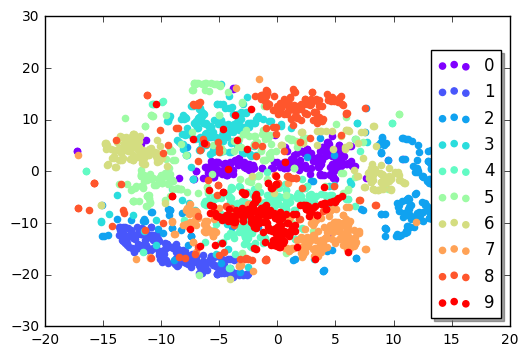

In [25]:
models = []
for num in range(bacth_times):
    idx = 0
    edx = idx+1
    
    z_out = sess.run(mean, feed_dict={x: np.expand_dims(data[num], axis=0)})
    models.append(z_out)


all_arr = models[0]
for i in range(1, len(models)):
     all_arr = np.concatenate(( all_arr, models[i]))

t_z = tsne.fit_transform(all_arr)

colors = ml.cm.rainbow(np.linspace(0, 1, 10))

for i in range(10):
    plt.scatter(t_z[200*i: 200*(i+1),0], t_z[200*i: 200*(i+1),1], marker='o', color = colors[i], label = str(i))

plt.legend(loc ='lower right', shadow = True)
plt.show()

# (b) Show the reconstruction loss, adversarial loss of generator and adversarial loss of discriminator in the training time.

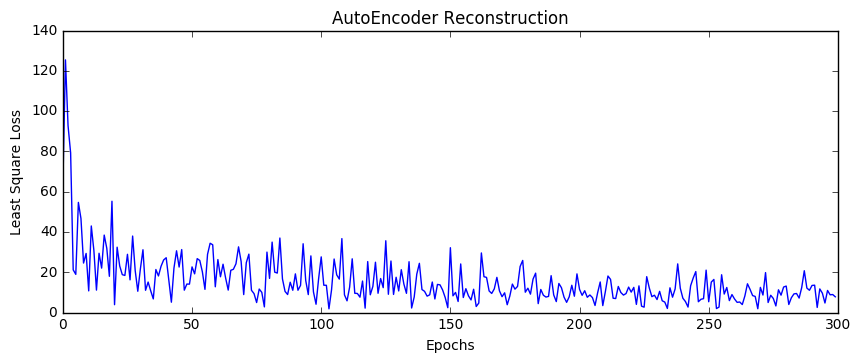

In [26]:

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.subplot(2, 1, 2)
plt.plot(re_list)
plt.title('AutoEncoder Reconstruction')
plt.xlabel('Epochs')
plt.ylabel("Least Square Loss")
plt.show()

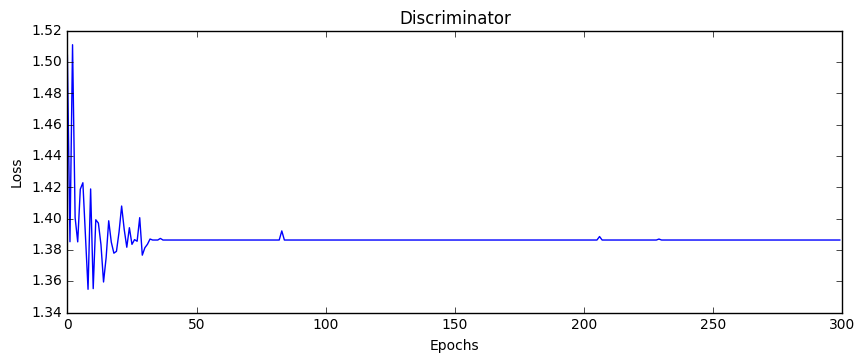

In [27]:

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.subplot(2, 1, 2)
plt.plot(dis_list)
plt.title('Discriminator')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.show()

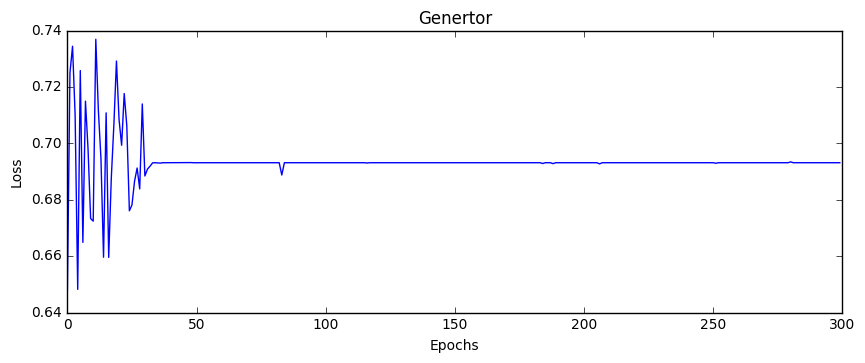

In [28]:

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

plt.subplot(2, 1, 2)
plt.plot(g_list)
plt.title('Genertor')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.show()

# (c) Explore the latent space and reconstruct the data through the decoder. (The output of decoder is 768-dimension, you should reshape the size to 28 x 28)


# Truth

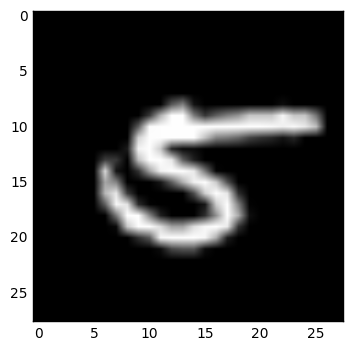

In [4]:
imgplot = plt.imshow(data[1000].reshape(28,28), cmap = 'gray')

# Reconstruct

In [68]:
def plot_features(data):
    #init_op = tf.global_variables_initializer()
    #sess.run(init_op)
    #pic = sess.run(x_reconstruct, {x:data})
    pic = sess.run(output, {x:data})

    #plt.imshow(pic[0])
    #print(pic)
    imgplot = plt.imshow(pic[0].reshape(28,28))
    #return pic

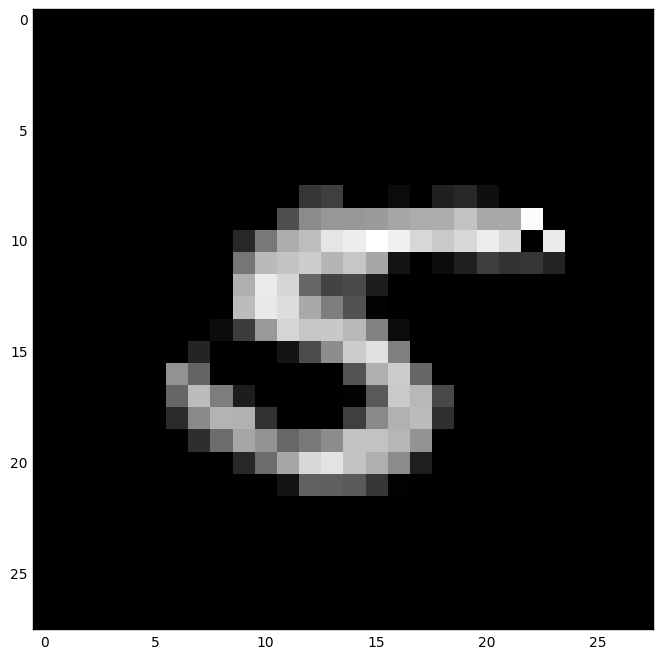

In [80]:
plot_features(np.expand_dims(data[1000], axis=0))

# LatentZ

In [31]:
def plot(samples):
    fig = plt.figure(figsize=(5, 5))   
    plt.imshow(samples.reshape(28, 28), cmap = 'gray')

    plt.show()

In [32]:
def plot_img(ori_list, n = 10):

    plt.figure(figsize=(1* 20, 4))

    for i in range(n):
        
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(ori_list[i].reshape(28, 28), cmap = 'gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.show()

In [151]:
list2 = []
for i in range(10):
    z = sample_Z(batch_size, z_dim)
    pic = sess.run(output2 , feed_dict ={distribution_z: z})
    list2.append(pic)

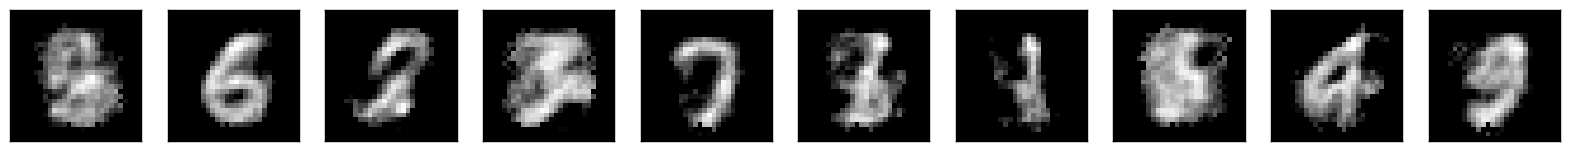

In [152]:
plot_img(list2)

In [127]:
list2 = []
for i in range(10):
    z = sample_Z(batch_size, z_dim)
    pic = sess.run(output2 , feed_dict ={distribution_z: z})
    list2.append(pic)

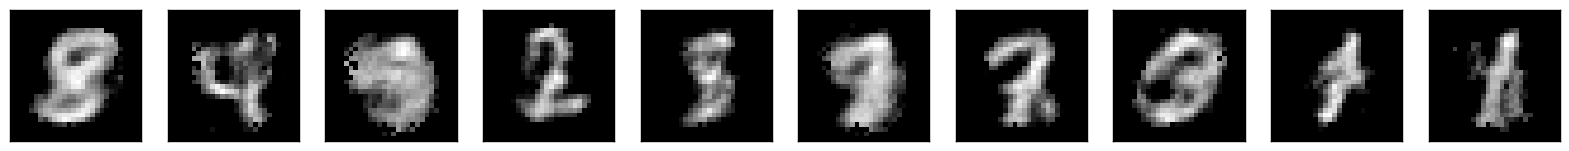

In [128]:
plot_img(list2)

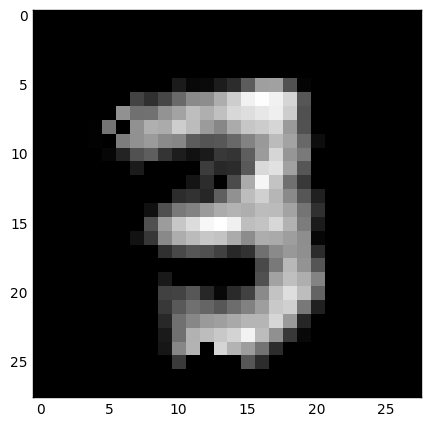

In [109]:
z = sample_Z(batch_size, z_dim)
z = z
pic = sess.run(output2 , feed_dict ={distribution_z: z})
plot(pic)

In [36]:
list = []
for i in range(10):
    z = sample_Z(batch_size, z_dim)
    pic = sess.run(output2 , feed_dict ={distribution_z: z})
    list.append(pic)

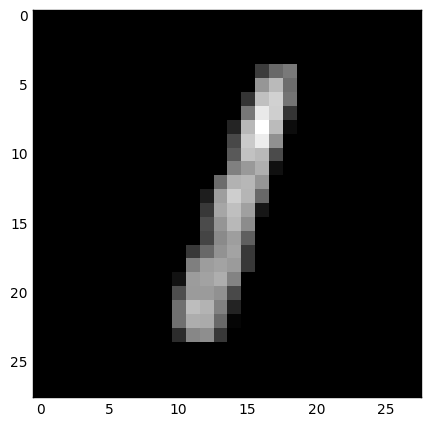

In [122]:
z = sample_Z(batch_size, z_dim)
z = z
pic = sess.run(output2 , feed_dict ={distribution_z: z})
plot(pic)